In [0]:
''' Please remove this cell when running in local context'''
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
from torchtext import *
from torchtext.data import *
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Preprocess Data and sanity check



In [0]:
# Define stopwords so that we can remove it from textfield
stop_words = set(stopwords.words('english'))   

# Define text and labael fields 
txt_field = data.Field(tokenize=word_tokenize, lower=True, include_lengths=True, batch_first=True, stop_words = stop_words)          
label_field = data.Field(sequential=False, use_vocab=False, batch_first=True)


''' 
in local context where this notebook is in the same folder as csv files, please change the path
-> path = './' 
'''
path = '/content/drive/My Drive/4211_ass2_data/part2/'        
#path = './' 

train, val, test= TabularDataset.splits(path=path, train='train.csv', validation='validation.csv', test='test.csv',      
                                        format='csv',fields=[('label', label_field),('text', txt_field)], skip_header=True)      

print("Data size sanity check:")
print("Train: {}".format(len(train.examples)))
print("Val: {}".format(len(val.examples)))
print("Test: {}".format(len(test.examples)))

Data size sanity check:
Train: 40000
Val: 5000
Test: 3000


### Build vocabulary and define iterators 

In [0]:
txt_field.build_vocab(train, min_freq=5)          
label_field.build_vocab(train)                     

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)

train_iter, val_iter, test_iter = data.BucketIterator.splits((train, val, test), batch_size=32, device = device,
                                                   sort_key=lambda x: len(x.text),sort_within_batch=True)

Device:  cuda


In [0]:
print('Sample training data:\n {}\n'.format(vars(train.examples[0])))
print('Sample valid. data:\n {}\n'.format(vars(val.examples[0])))

Sample training data:
 {'label': '1', 'text': ['guess', 'one-sided', 'relationship', 'sort', 'able', 'identify', 'lead', 'character', 'minako', 'yuko', 'tanaka', ',', '50', 'year', 'old', 'woman', 'still', 'pink', 'good', 'health', ',', 'demonstrated', 'daily', ',', 'grinding', 'routine', 'waking', 'extremely', 'early', 'morning', 'prepare', 'milk', 'delivery', 'work', ',', 'lug', 'bottles', 'megmilk', 'bag', 'route', 'around', 'town', 'like', 'clockwork', ',', 'exchange', 'empty', 'bottles', 'full', 'ones', ',', 'collect', 'payment', 'issue', 'receipt', '.', "'s", 'always', 'one', 'delivery', 'stop', "'s", 'right', 'top', ',', 'needing', 'scale', 'long', 'flight', 'stairs', 'order', 'achieve', 'customer', 'satisfaction', '.', 'peculiar', 'enough', ',', 'stop', 'happened', 'stop', 'delivering', 'man', 'love', 'almost', 'teenage', 'adult', 'life', ',', 'product', 'appreciated', ',', 'poured', 'sink', '.', 'gone', 'school', ',', 'see', "'re", 'talking', ',', 'daily', 'life', 'always', 's

### Recurrent Network Model

Constructor takes model number as input and configures the model accordingly

In [0]:
class Sentiment_RNN(nn.Module):
    def __init__(self, num_vocab, embedding_dim, num_hidden, num_layers, dropout_rate, pad_index, model_no):
        super(Sentiment_RNN, self).__init__()

        self.model_no = model_no
        assert self.model_no in [0,1,2,3,4] 
        
        #n_vocab = input dimension
        if self.model_no is not 4:
            self.emb = nn.Embedding(num_vocab, embedding_dim, padding_idx = pad_index)
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.num_vocab = num_vocab

        if self.model_no is 0: # Vanilla RNN
            self.rnn = nn.RNN(
                    input_size=embedding_dim,
                    hidden_size=num_hidden,
                    num_layers=num_layers,
                    dropout=dropout_rate,
                    batch_first=True
            ).cuda()
        elif self.model_no is 1: # GRU
            self.rnn = nn.GRU(
                    input_size=embedding_dim,
                    hidden_size=num_hidden,
                    num_layers=num_layers,
                    dropout=dropout_rate,
                    batch_first=True
            ).cuda()
        elif self.model_no is 2: # LSTM
            self.rnn = nn.LSTM(
                    input_size=embedding_dim,
                    hidden_size=num_hidden,
                    num_layers=num_layers,
                    dropout=dropout_rate,
                    batch_first=True
            ).cuda()
        elif self.model_no is 3: # LSTM + Bidirectional 
            self.rnn = nn.LSTM(
                    input_size=embedding_dim,
                    hidden_size=num_hidden,
                    num_layers=num_layers,
                    dropout=dropout_rate,
                    bidirectional = True,
                    batch_first=True
            ).cuda()
            num_hidden *= 2

        elif self.model_no is 4: # LSTM + No embedding
            self.rnn = nn.LSTM(
                    input_size=1,
                    hidden_size=num_hidden,
                    num_layers=num_layers,
                    dropout=dropout_rate,
                    batch_first=True
            ).cuda()
        
        self.fc = nn.Linear(num_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, sent, sent_len):

        if self.model_no is not 4:
            sent = self.dropout(self.emb(sent))
        else: # No embedding, directly feed raw integer values
            sent = sent.unsqueeze(-1).type(torch.float) 

        # pad the sequence
        packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len, batch_first=True)

        if self.model_no is 0 or self.model_no is 1:  #if vanilla or gru
            packed_outputs, hidden = self.rnn(packed)
        else:                                          # if lstm, which returns tuple
            packed_outputs, (hidden,cell) = self.rnn(packed)

        # Unpacking process, but no need for this task 
        # outputs, output_len = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        hidden = hidden.squeeze(0)

        if self.model_no is 3: #bidirectional, need to consider both forward and backward final hidden result
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        out = self.sigmoid(self.fc(self.dropout(hidden)))
        return out

### Saving and Loading helper functions (Reference: tutorials)

In [0]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}
    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer, save_path):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

#### Helper function for calculating accuracy based on given threshold for prediction

In [0]:
def get_accuracy(output, label, thresh):
    preds = ((output.data >= thresh)*1)
    correct = (preds == label).float()
    return correct.sum() / len(correct)

### Helper function for training

In [0]:
def TRAIN(model, iterator, optimizer, criterion, thresh):
    epoch_run_loss = 0.0
    epoch_run_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        text,text_len = batch.text
        output = model(text, text_len).squeeze(1)
        
        loss = criterion(output, batch.label.float())
        acc = get_accuracy(output, batch.label, thresh)
        
        loss.backward()
        optimizer.step()
        epoch_run_loss += loss.item()
        epoch_run_acc += acc.item()
        
    epoch_loss = epoch_run_loss/len(iterator)
    epoch_acc = epoch_run_acc/len(iterator)
    
    return epoch_loss, epoch_acc

### Helper function for evaluation (validation & testing)

In [0]:
def EVAL(model, iterator, criterion, thresh):
    epoch_run_loss = 0.0
    epoch_run_acc = 0
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text,text_len = batch.text
            output = model(text, text_len).squeeze(1)
            
            loss = criterion(output, batch.label.float())
            acc = get_accuracy(output, batch.label, thresh)
            
            epoch_run_loss += loss.item()
            epoch_run_acc += acc.item()
            
    epoch_loss = epoch_run_loss/len(iterator)
    epoch_acc = epoch_run_acc/len(iterator)
    
    return epoch_loss, epoch_acc

#### Helper function for printing model architecture (Reference: tutorials)

In [0]:
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n', model)
    print(f'\nThe model has {temp:,} trainable parameters\n')

### Helper function for the entire process

  - Takes model number as parameter and initializes a recurrent model accordingly
  - Performs training and evaluates every epoch
  - Collects history of losses and accuracies every epoch for later plotting 

In [0]:
import time

num_epoch = 20

criterion = nn.BCELoss().to(device)

def ACTION(model_no, num_epoch=num_epoch, criterion = criterion):
    model = Sentiment_RNN(num_vocab = len(txt_field.vocab), embedding_dim = 64, 
                          num_hidden = 128, num_layers = 1, dropout_rate = 0.5, 
                          pad_index= txt_field.vocab.stoi[txt_field.pad_token], model_no = model_no)
    model.to(device)
    print("Model No. {} Summary\n".format(model_no))
    count_parameters(model)

    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    save_path = 'sentiment_rnn{}.pt'.format(model_no)

    best_val_loss = float('inf')

    history = {}
    history['train_loss'], history['val_loss'] = [],[]
    history['train_acc'], history['val_acc'] = [],[]

    print('=============== Model {} Train Start =============\n'.format(model_no))

    for epoch in range(num_epoch):

        toc = time.time()

        # Train
        train_loss, train_acc = TRAIN(model, train_iter, optimizer, criterion, 0.5)
        # Validation evaluation
        val_loss, val_acc = EVAL(model, val_iter, criterion, 0.5)
        
        tic = time.time()

        # Append to loss history for plotting 
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
          
        print('Epoch {} Time: {:.1f} seconds'.format(epoch+1, tic-toc))
        print('Train Loss: {:.3f} Validation Loss: {:.3f}'.format(train_loss,val_loss))
        print('Train Acc.: {:.3f} Validation Acc.: {:.3f}'.format(train_acc,val_acc))
        
        # Saving model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(save_path, model, optimizer, best_val_loss)

    return model,history, save_path

### Baseline model training

In [0]:
model0,history0, save_path0 = ACTION(0) 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Model No. 0 Summary

The model architecture:
 Sentiment_RNN(
  (emb): Embedding(38200, 64, padding_idx=1)
  (rnn): RNN(64, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

The model has 2,469,761 trainable parameters

=============== Model 0 Train Start =============

Epoch 1 Time: 16.7 seconds
Train Loss: 0.686 Validation Loss: 0.657
Train Acc.: 0.555 Validation Acc.: 0.610
Model saved to ==> sentiment_rnn0.pt
Epoch 2 Time: 16.3 seconds
Train Loss: 0.640 Validation Loss: 0.617
Train Acc.: 0.639 Validation Acc.: 0.673
Model saved to ==> sentiment_rnn0.pt
Epoch 3 Time: 16.7 seconds
Train Loss: 0.618 Validation Loss: 0.564
Train Acc.: 0.663 Validation Acc.: 0.724
Model saved to ==> sentiment_rnn0.pt
Epoch 4 Time: 16.3 seconds
Train Loss: 0.633 Validation Loss: 0.548
Train Acc.: 0.646 Validation Acc.: 0.731
Model saved to ==> sentiment_rnn0.pt
Epoch 5 Time: 16.6 seconds
Train

### Model 1 training

In [0]:
model1,history1, save_path1 = ACTION(1)

Model No. 1 Summary

The model architecture:
 Sentiment_RNN(
  (emb): Embedding(38200, 64, padding_idx=1)
  (rnn): GRU(64, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

The model has 2,519,425 trainable parameters

=============== Model 1 Train Start =============



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 Time: 16.8 seconds
Train Loss: 0.649 Validation Loss: 0.610
Train Acc.: 0.615 Validation Acc.: 0.697
Model saved to ==> sentiment_rnn1.pt
Epoch 2 Time: 17.0 seconds
Train Loss: 0.603 Validation Loss: 0.583
Train Acc.: 0.671 Validation Acc.: 0.689
Model saved to ==> sentiment_rnn1.pt
Epoch 3 Time: 17.0 seconds
Train Loss: 0.467 Validation Loss: 0.430
Train Acc.: 0.782 Validation Acc.: 0.808
Model saved to ==> sentiment_rnn1.pt
Epoch 4 Time: 16.9 seconds
Train Loss: 0.372 Validation Loss: 0.340
Train Acc.: 0.838 Validation Acc.: 0.855
Model saved to ==> sentiment_rnn1.pt
Epoch 5 Time: 17.0 seconds
Train Loss: 0.325 Validation Loss: 0.308
Train Acc.: 0.862 Validation Acc.: 0.871
Model saved to ==> sentiment_rnn1.pt
Epoch 6 Time: 16.8 seconds
Train Loss: 0.290 Validation Loss: 0.294
Train Acc.: 0.879 Validation Acc.: 0.882
Model saved to ==> sentiment_rnn1.pt
Epoch 7 Time: 17.1 seconds
Train Loss: 0.267 Validation Loss: 0.288
Train Acc.: 0.891 Validation Acc.: 0.887
Model saved to 

### Model 2 training

In [0]:
model2,history2, save_path2 = ACTION(2)

Model No. 2 Summary

The model architecture:
 Sentiment_RNN(
  (emb): Embedding(38200, 64, padding_idx=1)
  (rnn): LSTM(64, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

The model has 2,544,257 trainable parameters

=============== Model 2 Train Start =============



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 Time: 17.8 seconds
Train Loss: 0.650 Validation Loss: 0.587
Train Acc.: 0.611 Validation Acc.: 0.689
Model saved to ==> sentiment_rnn2.pt
Epoch 2 Time: 17.6 seconds
Train Loss: 0.522 Validation Loss: 0.594
Train Acc.: 0.749 Validation Acc.: 0.746
Epoch 3 Time: 17.8 seconds
Train Loss: 0.444 Validation Loss: 0.504
Train Acc.: 0.800 Validation Acc.: 0.810
Model saved to ==> sentiment_rnn2.pt
Epoch 4 Time: 17.7 seconds
Train Loss: 0.390 Validation Loss: 0.428
Train Acc.: 0.831 Validation Acc.: 0.826
Model saved to ==> sentiment_rnn2.pt
Epoch 5 Time: 17.6 seconds
Train Loss: 0.349 Validation Loss: 0.637
Train Acc.: 0.854 Validation Acc.: 0.794
Epoch 6 Time: 18.0 seconds
Train Loss: 0.317 Validation Loss: 0.441
Train Acc.: 0.867 Validation Acc.: 0.844
Epoch 7 Time: 17.8 seconds
Train Loss: 0.291 Validation Loss: 0.405
Train Acc.: 0.880 Validation Acc.: 0.844
Model saved to ==> sentiment_rnn2.pt
Epoch 8 Time: 17.8 seconds
Train Loss: 0.275 Validation Loss: 0.480
Train Acc.: 0.889 Val

### Model 3 training

In [0]:
model3,history3, save_path3 = ACTION(3)

Model No. 3 Summary

The model architecture:
 Sentiment_RNN(
  (emb): Embedding(38200, 64, padding_idx=1)
  (rnn): LSTM(64, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

The model has 2,643,713 trainable parameters

=============== Model 3 Train Start =============



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 Time: 26.1 seconds
Train Loss: 0.624 Validation Loss: 0.584
Train Acc.: 0.639 Validation Acc.: 0.713
Model saved to ==> sentiment_rnn3.pt
Epoch 2 Time: 25.8 seconds
Train Loss: 0.528 Validation Loss: 0.524
Train Acc.: 0.744 Validation Acc.: 0.742
Model saved to ==> sentiment_rnn3.pt
Epoch 3 Time: 26.1 seconds
Train Loss: 0.433 Validation Loss: 0.441
Train Acc.: 0.802 Validation Acc.: 0.812
Model saved to ==> sentiment_rnn3.pt
Epoch 4 Time: 26.2 seconds
Train Loss: 0.379 Validation Loss: 0.454
Train Acc.: 0.837 Validation Acc.: 0.818
Epoch 5 Time: 26.6 seconds
Train Loss: 0.333 Validation Loss: 0.428
Train Acc.: 0.858 Validation Acc.: 0.841
Model saved to ==> sentiment_rnn3.pt
Epoch 6 Time: 26.2 seconds
Train Loss: 0.302 Validation Loss: 0.401
Train Acc.: 0.873 Validation Acc.: 0.865
Model saved to ==> sentiment_rnn3.pt
Epoch 7 Time: 25.9 seconds
Train Loss: 0.284 Validation Loss: 0.363
Train Acc.: 0.882 Validation Acc.: 0.875
Model saved to ==> sentiment_rnn3.pt
Epoch 8 Time: 2

### Model 4 training

In [0]:
model4,history4, save_path4 = ACTION(4)

Model No. 4 Summary

The model architecture:
 Sentiment_RNN(
  (rnn): LSTM(1, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

The model has 67,201 trainable parameters

=============== Model 4 Train Start =============



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 Time: 15.0 seconds
Train Loss: 0.693 Validation Loss: 0.689
Train Acc.: 0.516 Validation Acc.: 0.532
Model saved to ==> sentiment_rnn4.pt
Epoch 2 Time: 14.8 seconds
Train Loss: 0.684 Validation Loss: 0.678
Train Acc.: 0.555 Validation Acc.: 0.565
Model saved to ==> sentiment_rnn4.pt
Epoch 3 Time: 15.0 seconds
Train Loss: 0.679 Validation Loss: 0.676
Train Acc.: 0.569 Validation Acc.: 0.571
Model saved to ==> sentiment_rnn4.pt
Epoch 4 Time: 15.1 seconds
Train Loss: 0.679 Validation Loss: 0.680
Train Acc.: 0.572 Validation Acc.: 0.563
Epoch 5 Time: 14.9 seconds
Train Loss: 0.676 Validation Loss: 0.679
Train Acc.: 0.577 Validation Acc.: 0.574
Epoch 6 Time: 15.2 seconds
Train Loss: 0.675 Validation Loss: 0.674
Train Acc.: 0.576 Validation Acc.: 0.578
Model saved to ==> sentiment_rnn4.pt
Epoch 7 Time: 15.0 seconds
Train Loss: 0.673 Validation Loss: 0.679
Train Acc.: 0.578 Validation Acc.: 0.575
Epoch 8 Time: 15.0 seconds
Train Loss: 0.672 Validation Loss: 0.672
Train Acc.: 0.584 Val

## Helper function for testing

In [0]:
# Collect the details of all five models
model_list = [model0,model1,model2,model3,model4]
save_path_list = [save_path0,save_path1,save_path2,save_path3,save_path4]
history_list = [history0, history1,history2,history3,history4]

def TEST(model_no, verbose = True):
    model = model_list[model_no]
    test_loss, test_acc = EVAL(model, test_iter, criterion, 0.5)

    if verbose:
        print('Model {} Test performance'.format(model_no))
        print('Test Loss: {:.3f}'.format(test_loss))
        print('Test Acc.: {:.3f}'.format(test_acc))
    return test_loss, test_acc

### Helper functin for plotting losses and accuracies
  - Takes list of model numbers as parameter and plots losses/accuracies of all the model numbers given

In [0]:
plt.rcParams['figure.figsize'] = (15,10)

def loss_plot(models, epochs):
    epochs = np.arange(1,epochs+1)
    num_models = len(models)

    for i in range(num_models):
        assert i in [0,1,2,3,4] 
        plt.subplot(1, num_models,i+1)
        plt.title("Model{}".format(models[i]))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.ylim(0,0.8)
        plt.plot(epochs, history_list[models[i]]['train_loss'], label = "Training Loss")
        plt.plot(epochs, history_list[models[i]]['val_loss'], label = "Validation Loss")
        plt.legend()
    plt.tight_layout()
    plt.show()


def acc_plot(models, epochs):
    epochs = np.arange(1,epochs+1)
    num_models = len(models)

    for i in range(num_models):
        assert i in [0,1,2,3,4] 
        plt.subplot(1, num_models,i+1)
        plt.title("Model{}".format(models[i]))
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.ylim(0,1)
        plt.plot(epochs, history_list[models[i]]['train_acc'], label = "Training Accuracy")
        plt.plot(epochs, history_list[models[i]]['val_acc'], label = "Validation Accuracy")
        plt.legend()
    plt.tight_layout()
    plt.show()

### Basline model testing accuracy

In [0]:
# Dictionary to store testing loss and accuracies of all five models
model_test_losses = {}
model_test_accs = {}

baseline_test_loss, baseline_test_acc = TEST(0) # Testing

model_test_losses[0] = baseline_test_loss
model_test_accs[0] = baseline_test_acc

Model 0 Test performance
Test Loss: 0.549
Test Acc.: 0.709


### Baseline Model vs Model 1 vs Model 2

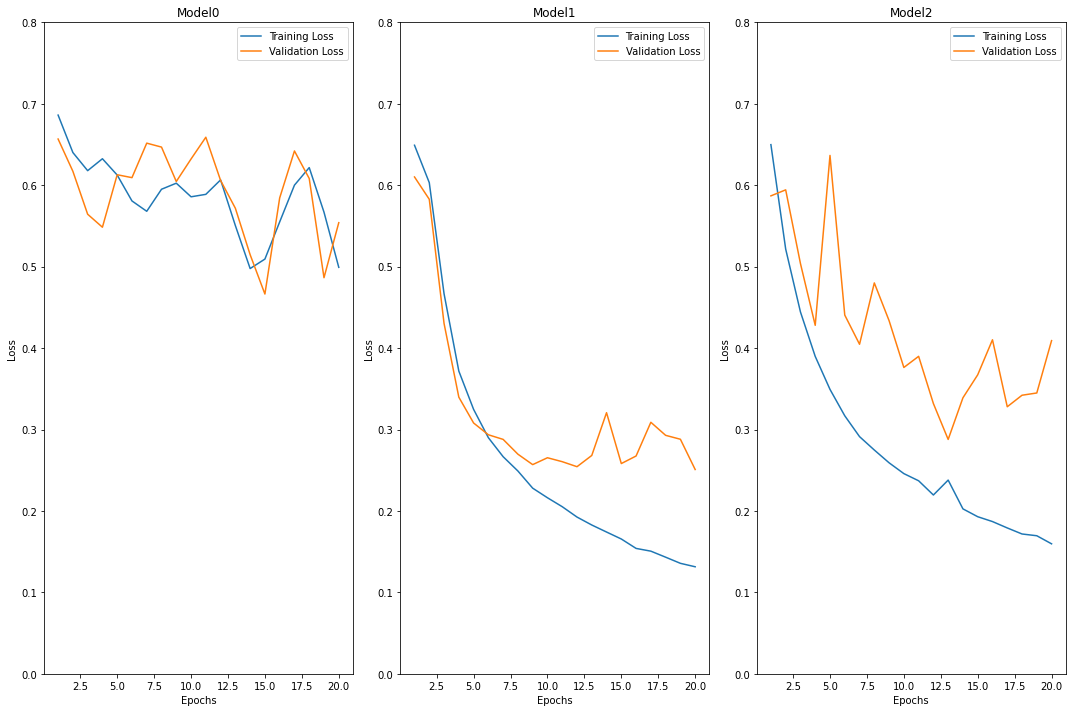

In [49]:
loss_plot([0,1,2],num_epoch)

### Model 2 vs Model 3 (effect of bidirection)

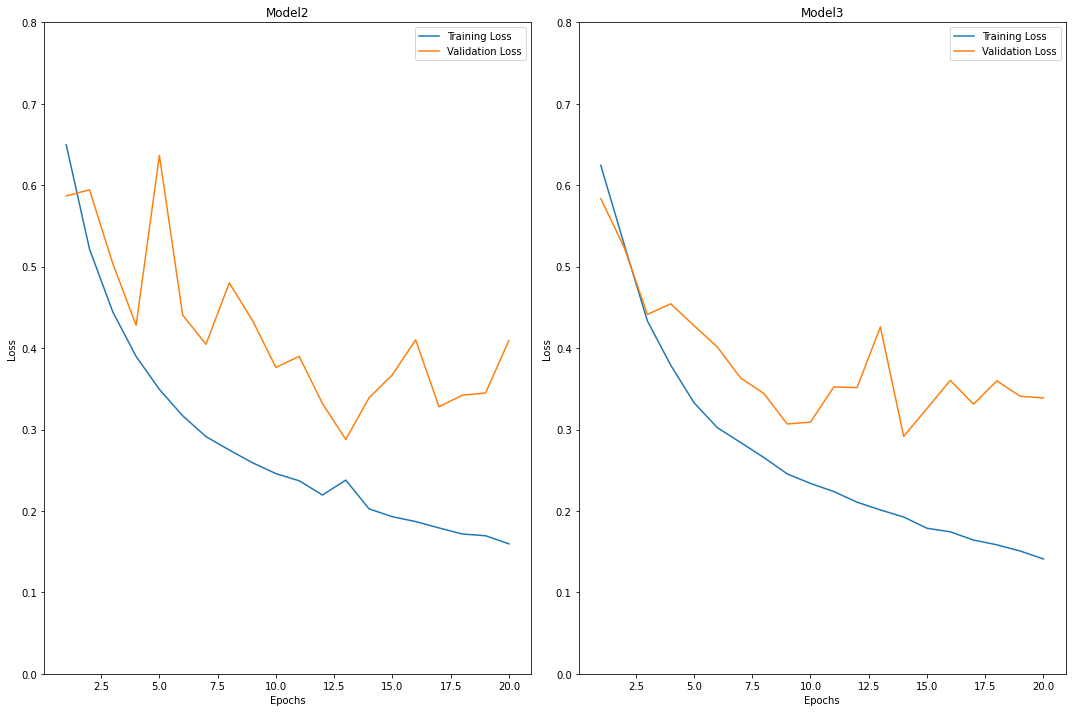

In [50]:
loss_plot([2,3],num_epoch)

### Model 2 vs Model 4 (effect of embedding)

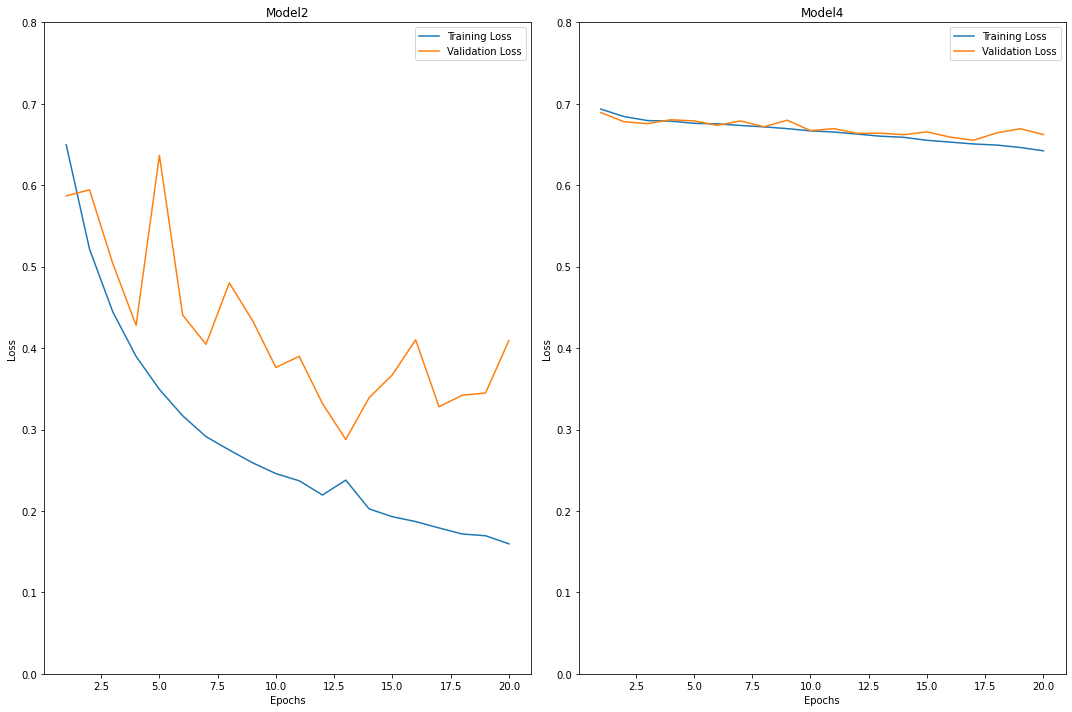

In [51]:
loss_plot([2,4],num_epoch)

### Test remaining models and rank performance

In [0]:
# Perform testing of remaining four models
for i in range(1,5):
    loss, acc = TEST(i, False)
    model_test_losses[i] = loss
    model_test_accs[i] = acc

# Sort the models by accuracy and report
sorted_model_test_acc = sorted(model_test_accs.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)
print("Performances of different models: \n")
for i, model in enumerate(sorted_model_test_acc):
    print("Rank {}: Model {} with test accuracy of {:.3f}".format(i+1, model[0], model[1]))

Performances of different models: 

Rank 1: Model 1 with test accuracy of 0.910
Rank 2: Model 3 with test accuracy of 0.895
Rank 3: Model 2 with test accuracy of 0.885
Rank 4: Model 0 with test accuracy of 0.709
Rank 5: Model 4 with test accuracy of 0.600


### Play with word embedding and observe distance 

In [0]:
best_model = model1

good_val = predict_word_embedding(best_model, 'good')
happy_val = predict_word_embedding(best_model, 'happy')
bad_val = predict_word_embedding(best_model, 'bad')
boring_val = predict_word_embedding(best_model, 'boring')

print("good: {:.3f}\nhappy: {:.3f}\nbad: {:.3f}\nboring: {:.3f}\n".format(good_val,happy_val,bad_val,boring_val)) 

print("good vs happy: {:.3f}".format(l2_distance(good_val, happy_val)))
print("boring vs bad: {:.3f}".format(l2_distance(boring_val, bad_val)))
print("good vs boring: {:.3f}".format(l2_distance(good_val, boring_val)))

good: 0.824
happy: 0.816
bad: 0.085
boring: 0.031

good vs happy: 0.009
boring vs bad: 0.053
good vs boring: 0.793
